## Visualizing results 3rd Edition-  SpaCy Geottaging + Edinburgh Georesolution

In this case, we have used the [SpaCy en_core_web_lg](https://spacy.io/models/en#en_core_web_lg) for finding the Name Entities of all the books of a particular edition,  and select the ones regarding with places (GPE and LOC entities). Later, once we have the locations entities, we use the [georesolver]() of the  [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to resolve these locations.

We have used the **Third Edition of the Encyclopaedia Britannica**. 
                             
The query for running that we have used is the following: 

`spark-submit --py-files defoe.zip defoe/run_query.py nls_third_edition.txt nls defoe.nls.queries.georesolution_pages queries/lang_model.yml -r georesolution_en_core_web_lg_EB_third_edition' -n 16`


And the queries/lang_model.yml specifies the spaCy language model to use:
`lang_model: en_core_web_lg`


### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]
    for i in result.keys():
        t_ind = 0
        e_ind = 0
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
       
            if locs != {}:
                data=[]
                l_ind = 0
                for i in locs:
                    if type(locs[i]) == type([]) :
                        c_locs=locs[i].copy()
                        c_locs.append(i.split("-")[0])
                        c_locs.append(page)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df_total['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [5]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'])
        if place_name not in filter_list:
            print(i, place_count,place_name)
            if place_name not in place_label:
                k = k + 1
            place_label.append(place_name)
            place_freq.append(place_count)
         
        i = i + 1
    return place_label, place_freq

In [6]:
def plot_bar_places(df_group_places):
    # this is for plotting purpose
    index = np.arange(len(df_group_places['place_label']))
    plt.bar(index, df_group_places['count'], color='green')
    plt.xlabel('Places')
    plt.ylabel('Frequency of Places')
    plt.xticks(index, df_group_places['place_label'], rotation=40, fontsize=8)
    plt.title('15 Places most mentioned using SpaCy and the Georesolver')

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages from the directory "144133901",  which corresponds to the book "Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 1, A-B - EB.1"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original SpaCy en_core_web_lg model.
- From the previous entities, just selects the one about *location* (GPE and LOC) and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by Book's title, and also gets some informative metadata


As a result we get a file per gazetter|book with an entry per page with the following information:

    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver 
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (en_core_web_lg)
    * year: Publication year 



In [7]:
results=read_query_results('georesolution_en_core_web_lg_EB_third_edition')
results_suplement = read_query_results('georesolution_en_core_web_lg_EB_third_sumplement')

In [8]:
df1= geresolution_dataframe(results)
df2 = geresolution_dataframe(results_suplement)
frames = [df1, df2]

df_total = pd.concat(frames)


In [9]:
df_total[["Place"]].count()

Place    187065
dtype: int64

In [10]:
df_total["Place"]= df_total["Place"].str.capitalize()

In [11]:
df_total.groupby("Place").count()

,Latitude,Longitude,Page
Place,,,
# city,1,1,1
"0,00053",1,1,1
"0,000732",1,1,1
"0,536",1,1,1
"0,9335",1,1,1
0114,1,1,1
1,2,2,2
1 america,1,1,1
1 city,1,1,1


In [12]:
#df_total.groupby("Page").count()

In [13]:
#df_total.groupby(["Latitude", "Longitude"]).count()

In [14]:
df_filter = df_total[['Latitude','Longitude']].groupby(['Latitude', 'Longitude'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   

df_max_geolocations = df_filter.drop(0)

df_max_geolocations.head(15)


,Latitude,Longitude,count
12281,43.2256251,-75.48878740000001,2874
7295,38.3242916,-76.5168989,2779
5323,34.6120507,-82.765139,2215
18409,54,-4,1904
7626,38.7937266,-77.8577722,1491
11829,42.7578673,-71.2422828,1472
5228,34.350601,-85.15801399999999,1462
15656,49.012779,2.55,1423
11500,42.4514848,-71.0864414,1419
3493,27.5197607,-82.5173183,1162


In [15]:
#Getting the 15 places (and their frequencies) most mentioned
filter_list=['Earth', 'The moon', 'Meridian', 'Jupiter', 'Venus', 'Kingdom']
place_label, place_freq = label_freq_places(df_total, df_max_geolocations, filter_list)
    

0 2874 Rome
2 2215 France
3 1904 Ireland
4 1491 England
5 1472 England
6 1462 Rome
7 1423 Paris
8 1419 England
10 1149 France
11 1144 Italy
12 1088 Europe
13 1084 France
14 1068 Holland
15 1058 Edinburgh
16 1049 Europe
17 1030 Scotland
18 974 Scotland
19 971 Asia
20 963 England
21 939 London
22 915 Scotland
23 790 Venice
24 730 Britain
26 719 Rome
27 698 England
28 684 America


In [16]:
#Visualizing the 15 places in a Bar plot
df_places = {'place_label':place_label,'place_freq':place_freq}
df_places_freq = pd.DataFrame(df_places)
df_group_places = df_places_freq.groupby(['place_label'])['place_freq'].sum()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   


df_group_places

,place_label,count
4,England,6043
12,Rome,5055
6,France,4448
13,Scotland,2919
5,Europe,2137
8,Ireland,1904
11,Paris,1423
9,Italy,1144
7,Holland,1068
3,Edinburgh,1058


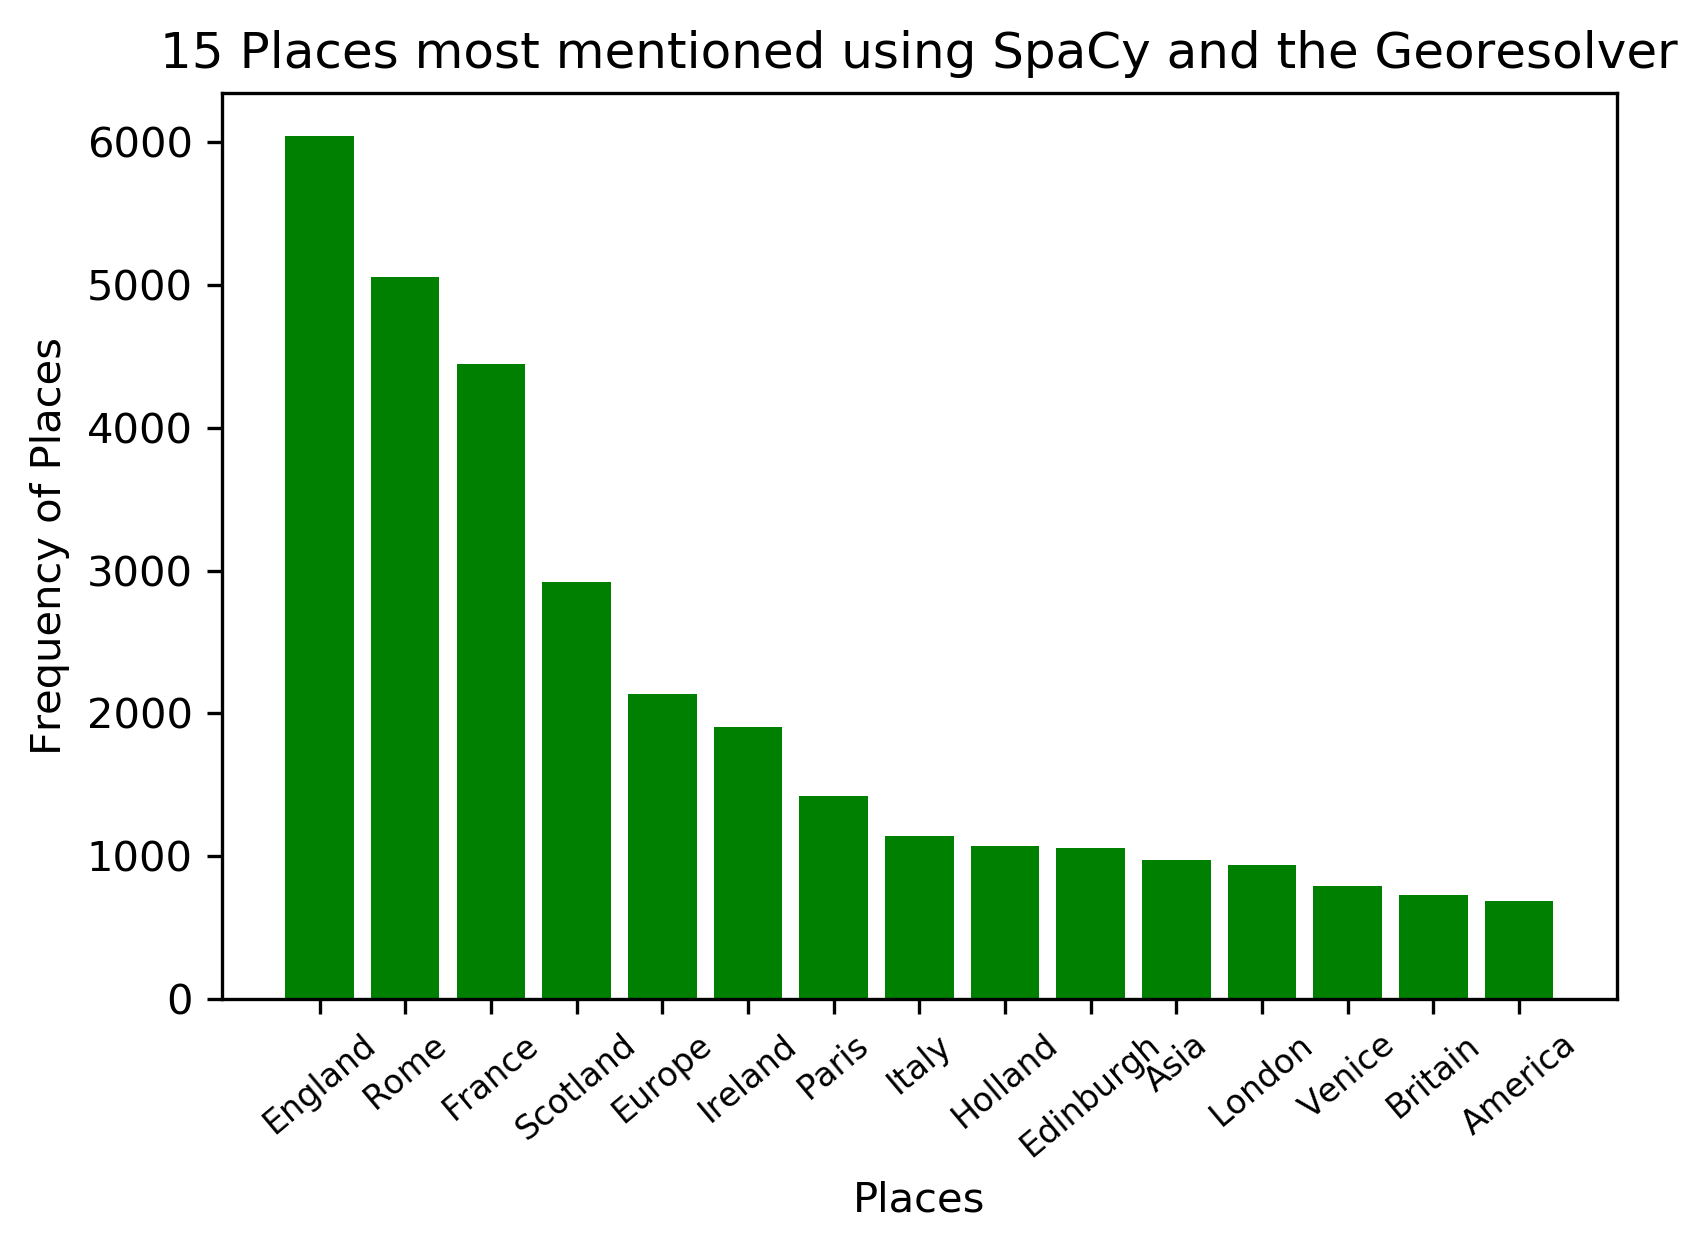

In [17]:
mpl.rcParams['figure.dpi']=300
plot_bar_places(df_group_places)